 ## Defining the problem and assembling a dataset

- Keras Fashion MNIST Dataset
  - https://keras.io/api/datasets/fashion_mnist/
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation and test sets
- Doing K-fold cross-validation

## Preparing your data

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [35]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [36]:
X_train, X_test = X_train[:20000,:], X_test[:2500,:]

y_train, y_test = y_train[:20000], y_test[:2500]

In [37]:
# covert image from color to gray scale
# trainX, testX = rgb2gray(trainX), rgb2gray(testX)

In [38]:
WIDTH = 16
HEIGHT = 16

# resize image
X_train = resize(X_train, (X_train.shape[0], WIDTH, HEIGHT), anti_aliasing=True)
X_test = resize(X_test, (X_test.shape[0], WIDTH, HEIGHT), anti_aliasing=True)

In [39]:
X_train = X_train.reshape((X_train.shape[0],-1))
X_test = X_test.reshape((X_test.shape[0],-1))

In [40]:
scaler = StandardScaler().fit(X_train)

X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [43]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = np_utils.to_categorical(label_encoder.transform(y_train))
y_test = np_utils.to_categorical(label_encoder.transform(y_test))

In [44]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [52]:
counts = np.sum(y_train, axis=0)

counts

array([1693., 1772., 1734., 1760., 1721., 1759., 1809., 1753., 1725.,
       1774.], dtype=float32)

In [53]:
baseline = max(counts) / sum(counts)

baseline

0.10337142857142857

In [54]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                                     dropout=np.nan, input_dimension=2, output_dimension=1,
                                     optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                                     name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [55]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [57]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_CLASSES = y_train.shape[1]

OPTIMIZER = 'RMSprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

In [58]:
slp_model = deep_neural_network(hidden_layers=0,
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 2,570
Trainable params: 2,570
Non-trainable params: 0
_________________________________________________________________


In [59]:
batch_size = 128
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [60]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [61]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.83 (baseline=0.10)
Precision (Validation): 0.87
Recall (Validation): 0.80
AUC (Validation): 0.98


In [62]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

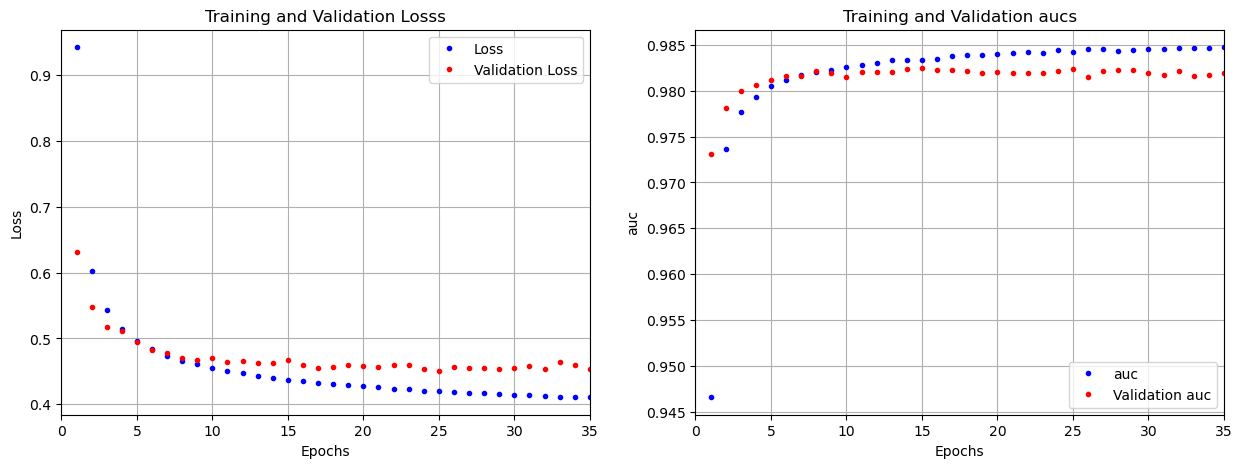

In [63]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [68]:
mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=8,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
Total params: 2,146
Trainable params: 2,146
Non-trainable params: 0
_________________________________________________________________


In [69]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=100, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

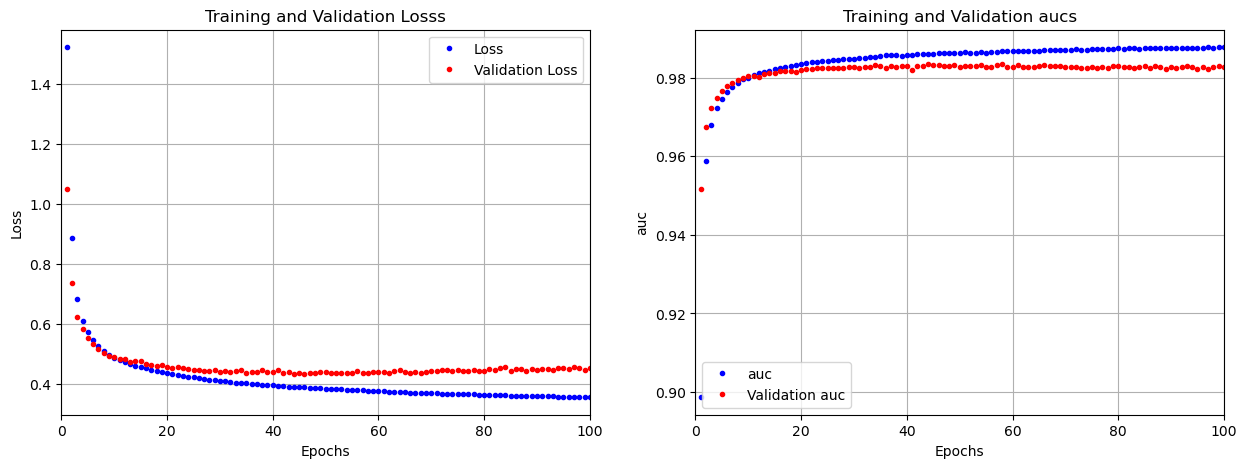

In [70]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [71]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.84 (baseline=0.10)
Precision (Validation): 0.87
Recall (Validation): 0.82
AUC (Validation): 0.98


 ## Regularizing your model and tuning your hyperparameters

In [72]:
# Compute Balanced Accuracy Score for Softmax One-Hot Encoded Output
def compute_balanced_accuracy_score(y, preds) :
    return balanced_accuracy_score(y, preds.flatten())

# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [73]:
# Grid Search CV
def grid_search_cv(X, y,
                   space, cv, 
                   optimizer, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y.argmax(axis=1)) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=optimizer, loss=loss, 
                                        metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate,:]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate,:], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = trained['model'].predict(X[validate,:], verbose=0)
                evaluations.append( value(y[validate,:], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [74]:
addon_metrics = {}

orders = {
    0: 'categorical_accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
}

In [75]:
KFOLDS = 5

In [76]:
params = {
    'hidden_layers': [1],
    'neurons': [4, 8, 16],
    'activation': ['relu'],
    'dropout': [0.2],
    'batch_size': [128]
}

stats = grid_search_cv(X_train, y_train,  
                       space=params, cv=KFOLDS, 
                       optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

In [77]:
stats.sort_values(by=['categorical_accuracy'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc
2,1,16,relu,0.2,128,47.0,0.432865,0.845714,0.879079,0.811086,0.983678
1,1,8,relu,0.2,128,55.6,0.513895,0.819029,0.886387,0.756914,0.979301
0,1,4,relu,0.2,128,83.2,0.753890,0.748571,0.908501,0.548914,0.962699


In [78]:
opt_model = deep_neural_network(hidden_layers=1, hidden_neurons=16,
                                dropout=0.2, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_CLASSES,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Deep_Wide_Network')

opt_model.summary()

Model: "Deep_Wide_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 16)                4112      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_36 (Dense)            (None, 10)                170       
                                                                 
Total params: 4,282
Trainable params: 4,282
Non-trainable params: 0
_________________________________________________________________


In [79]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

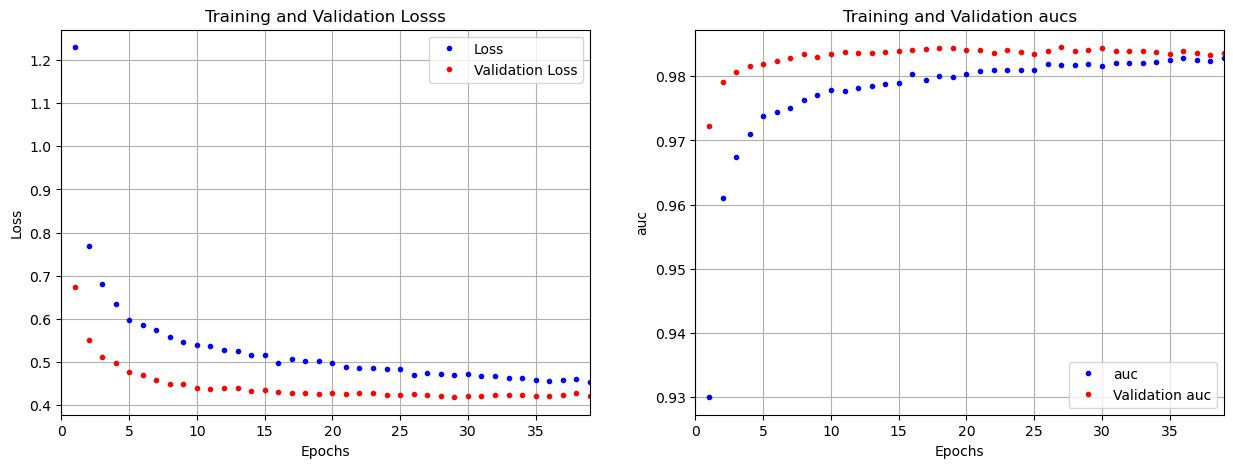

In [80]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [81]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.85 (baseline=0.10)
Precision (Validation): 0.89
Recall (Validation): 0.82
AUC (Validation): 0.98


In [82]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test.argmax(axis=1), 
                                                                      preds.argmax(axis=1)), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test.argmax(axis=1), 
                                                        preds.argmax(axis=1),
                                                        average='macro')))
print('Recall (Test): {:.2f}'.format(recall_score(y_test.argmax(axis=1), 
                                                  preds.argmax(axis=1),
                                                  average='macro')))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, 
                                                preds,
                                                multi_class='ovo',
                                                average='macro')))

Accuracy (Test): 0.85 (baseline=0.10)
Precision (Test): 0.85
Recall (Test): 0.85
AUC (Test): 0.99


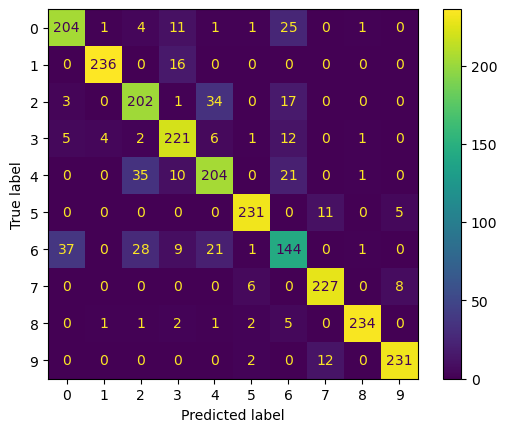

In [85]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=range(10))
_ = disp.plot()